# **Install & Import Library**

In [2]:
# Install SciPy (untuk L-BFGS) dan TensorFlow jika belum terpasang
!pip install -q scipy
!pip install -q tensorflow==2.17.1

# Import library utama
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import scipy.optimize

print("Tahap 1 selesai — library siap digunakan.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 903.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but

# **Load & Preprocess Image**

In [13]:
from PIL import Image
import numpy as np
import tensorflow as tf

TARGET_SIZE = (512, 768)   # (height=512, width=768)

def load_and_process_image(path):
    img = Image.open(path).convert('RGB')

    # Resize ke ukuran final yang sudah kita tentukan
    img = img.resize(TARGET_SIZE[::-1])   # PIL pakai (width, height)

    img = np.array(img).astype('float32')
    img = np.expand_dims(img, axis=0)

    # Preprocessing VGG19
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

print("Tahap 2 FINAL selesai — semua gambar sekarang 512×768 px.")

Tahap 2 FINAL selesai — semua gambar sekarang 512×768 px.


# **Upload & Tentukan Path Gambar**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive sudah ter-mount.")

Mounted at /content/drive
Google Drive sudah ter-mount.


In [14]:
content_path = "/content/drive/MyDrive/algoritma/Deep Learning/Datasets/Gambar/Burj 512.png"
style_path   = "/content/drive/MyDrive/algoritma/Deep Learning/Datasets/Style/mosaik 512.png"
print("Content path :", content_path)
print("Style path   :", style_path)

print("\nTahap 3 selesai — path gambar siap digunakan.")

Content path : /content/drive/MyDrive/algoritma/Deep Learning/Datasets/Gambar/Burj 512.png
Style path   : /content/drive/MyDrive/algoritma/Deep Learning/Datasets/Style/mosaik 512.png

Tahap 3 selesai — path gambar siap digunakan.


# **VGG19 Feature Extractor**

In [15]:
# Layer untuk STYLE
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Layer untuk CONTENT
content_layers = ['block5_conv2']

num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

# Fungsi untuk mengambil output dari layer-layer yang kita pilih
def build_vgg_model():
    # Load VGG19 tanpa fully-connected layers (top=False)
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Ambil output dari setiap layer style + content
    outputs = [
        vgg.get_layer(name).output
        for name in (style_layers + content_layers)
    ]

    # Model akan menghasilkan fitur style dan content sekaligus
    model = tf.keras.Model([vgg.input], outputs)
    model.trainable = False
    return model

# Buat model VGG19 untuk ekstraksi fitur
feature_extractor = build_vgg_model()

print("Tahap 4 selesai — VGG19 feature extractor siap digunakan.")

Tahap 4 selesai — VGG19 feature extractor siap digunakan.


# **Ekstraksi Fitur Style dan Content + Gram Matrix**

In [17]:
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    num_locations = tf.cast(tf.shape(tensor)[1] * tf.shape(tensor)[2], tf.float32)
    return result / num_locations

def get_style_and_content_features(content_path, style_path):
    # Content image (512×768)
    content_image = load_and_process_image(content_path)

    # Style image di-resize ke ukuran 512×768
    style_img_raw = Image.open(style_path).convert("RGB")
    style_img_raw = style_img_raw.resize((768, 512))  # (width=768, height=512)

    style_image = np.array(style_img_raw).astype('float32')
    style_image = np.expand_dims(style_image, axis=0)
    style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

    # Ekstraksi fitur
    style_outputs = feature_extractor(style_image)
    content_outputs = feature_extractor(content_image)

    # Pisahkan layer output
    style_features = style_outputs[:num_style_layers]
    content_features = content_outputs[num_style_layers:]

    # Gram Matrix untuk style
    style_features = [gram_matrix(feat) for feat in style_features]

    return style_features, content_features

style_features, content_features = get_style_and_content_features(content_path, style_path)

print("Tahap 5 FINAL selesai — fitur siap.")

Tahap 5 FINAL selesai — fitur siap.


# **Loss Function untuk NST (Content + Style)**

In [18]:
# Bobot gaya dan konten
style_weight = 1e-2
content_weight = 1e4

# Fungsi perhitungan total loss NST
def compute_loss(model_outputs, style_features, content_features):
    # Model_outputs = [style layer outputs..., content layer outputs...]
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    # ------ STYLE LOSS ------
    style_score = 0
    for comb_style, target_style in zip(style_output_features, style_features):
        gram_comb = gram_matrix(comb_style)
        style_score += tf.reduce_mean(tf.square(gram_comb - target_style))
    style_score /= num_style_layers

    # ------ CONTENT LOSS ------
    content_score = 0
    for comb_content, target_content in zip(content_output_features, content_features):
        content_score += tf.reduce_mean(tf.square(comb_content - target_content))
    content_score /= num_content_layers

    # ------ TOTAL LOSS ------
    total_loss = style_weight * style_score + content_weight * content_score

    return total_loss, style_score, content_score

print("Tahap 6 selesai — loss function siap digunakan.")

Tahap 6 selesai — loss function siap digunakan.


# **Optimasi dengan L-BFGS**

Menjalankan optimasi L-BFGS...
(Proses ini memakan waktu ±20–60 detik tergantung GPU Colab.)


/tmp/ipython-input-2683181992.py:36: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = scipy.optimize.minimize(



Optimasi selesai!


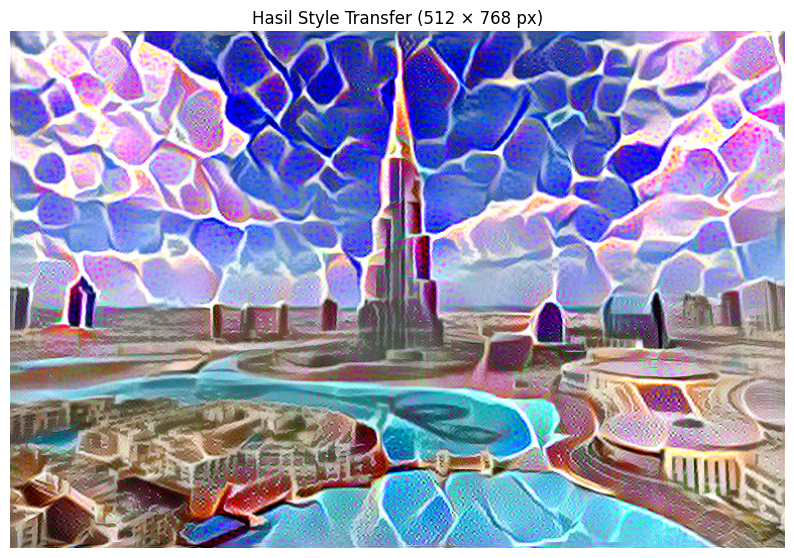

Tahap 7 FINAL selesai — gambar siap disimpan di Tahap 8.


In [20]:
# Ambil ulang fitur style & content
style_features, content_features = get_style_and_content_features(content_path, style_path)

# Gambar awal = content image
initial_image = load_and_process_image(content_path)
initial_image = tf.Variable(initial_image, dtype=tf.float32)

# Helper function: flatten tensor menjadi bentuk 1D (dibutuhkan L-BFGS)
def tensor_to_flat(x):
    return x.numpy().astype('float64').ravel()

# Helper function: restore 1D array menjadi tensor gambar
def flat_to_tensor(x_flat, shape):
    x = np.array(x_flat, dtype='float32').reshape(shape)
    return tf.convert_to_tensor(x)

# Fungsi utama L-BFGS (mengembalikan loss & gradient)
def lbfgs_loss_and_grad(x_flat):
    # Kembalikan dari 1D → tensor gambar
    x_tensor = flat_to_tensor(x_flat, initial_image.shape)

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        outputs = feature_extractor(x_tensor)
        loss, style_l, content_l = compute_loss(outputs, style_features, content_features)

    # Hitung gradien dan flatten
    grad = tape.gradient(loss, x_tensor)
    grad_flat = grad.numpy().astype('float64').ravel()

    return loss.numpy().astype('float64'), grad_flat

print("Menjalankan optimasi L-BFGS...\n(Proses ini memakan waktu ±20–60 detik tergantung GPU Colab.)")

# ---- Jalankan L-BFGS ----
result = scipy.optimize.minimize(
    fun=lbfgs_loss_and_grad,
    x0=tensor_to_flat(initial_image),
    method='L-BFGS-B',
    jac=True,
    options={'maxiter': 100, 'disp': True}
)

print("\nOptimasi selesai!")

# ---- Konversi hasil menjadi gambar final ----
generated_image = flat_to_tensor(result.x, initial_image.shape)
generated_image = generated_image.numpy()
stylized_image = deprocess_image(generated_image)

# ---- Tampilkan hasil ----
plt.figure(figsize=(10, 8))
plt.imshow(stylized_image)
plt.axis("off")
plt.title("Hasil Style Transfer (512 × 768 px)")
plt.show()

print("Tahap 7 FINAL selesai — gambar siap disimpan di Tahap 8.")

# **Simpan Gambar Hasil Style Transfer**

Hasil berhasil disimpan di: /content/stylized_result_512x768.jpg


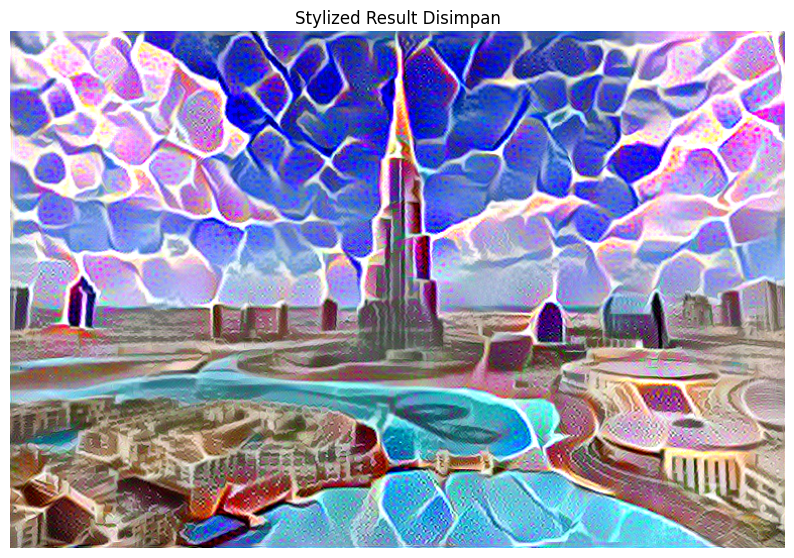

In [21]:
# Simpan hasil ke file JPEG
output_path = "/content/stylized_result_512x768.jpg"
Image.fromarray(stylized_image).save(output_path)

print("Hasil berhasil disimpan di:", output_path)

# Tampilkan hasil sekali lagi
plt.figure(figsize=(10, 8))
plt.imshow(stylized_image)
plt.axis("off")
plt.title("Stylized Result Disimpan")
plt.show()